In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sc
import statsmodels.graphics.gofplots as sm
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

#### Read in data file

In [4]:
data = pd.read_csv("/Users/FM/Public/HDS/Summer Project/wastewater_r_estimation/Linked Data.csv")
data.head()

,Unnamed: 0,date,weighted_avg_sars_cov2,gene_copies_per_day,weighted_average_r,log_weighted_avg,log_gc_per_day,region
0,0,2020-09-04,101.375432,6.940908e+10,0.949947,2.005933,10.841416,south west
1,1,2020-09-05,102.447339,7.014299e+10,0.964242,2.010501,10.845984,south west
2,2,2020-09-06,103.519246,7.087689e+10,0.978536,2.015021,10.850505,south west
3,3,2020-09-07,1631.590242,1.117107e+12,0.992831,3.212611,12.048095,south west
4,4,2020-09-08,1479.650801,1.013078e+12,1.007125,3.170159,12.005643,south west


#### Univariable XGBoost Regressor

In [10]:
x = data.iloc[:, 5] # log weighted average RNA level
y = data.iloc[:, 4] # weighted R estimate avg

0       0.949947
1       0.964242
2       0.978536
3       0.992831
4       1.007125
          ...   
1435    0.899438
1436    0.899438
1437    0.899438
1438    0.899438
1439    0.899438
Name: weighted_average_r, Length: 1440, dtype: float64

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 100)
# 75% data for training and 25% for test

xg_reg = XGBRegressor()

In [12]:
xg_reg.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [13]:
# Test data
y_pred = xg_reg.predict(x_test)

In [14]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)

In [15]:
print("MSE: %0.2f" % (mse))

MSE: 0.04


In [16]:
rmse = np.sqrt(mse)
print ("RMSE: %0.2f" % (rmse))

RMSE: 0.21


In [17]:
from sklearn.model_selection import cross_val_score
model = XGBRegressor(objective = "reg:squarederror")
scores = cross_val_score(model, x, y,
                         scoring = "neg_mean_squared_error",
                         cv = 10)

In [18]:
scores

array([-0.04599956, -0.03612224, -0.03833347, -0.04508599, -0.03800276,
       -0.04987045, -0.04108023, -0.07740534, -0.0461686 , -0.04886461])

10

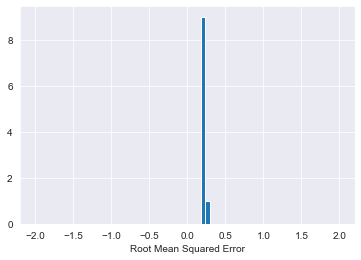

In [19]:
rmse = np.sqrt(-scores)
plt.hist(rmse, 75, range=(-2, 2))
plt.xlabel('Root Mean Squared Error')
rmse.size

In [20]:
# Plot predicted R values
y_pred

array([0.9258788 , 1.116136  , 1.1466405 , 1.1173491 , 1.0800848 ,
       1.0916666 , 1.0113691 , 1.0606176 , 0.9955681 , 1.0424157 ,
       1.0349685 , 1.2016971 , 1.2391032 , 1.1457933 , 1.2181566 ,
       1.301002  , 0.91393435, 1.1345447 , 1.0983903 , 1.0460883 ,
       1.1660638 , 1.1099601 , 1.0424157 , 1.1233057 , 1.177742  ,
       1.1940601 , 1.12951   , 1.1267658 , 1.0774144 , 1.287475  ,
       0.954096  , 0.9541628 , 1.0943719 , 1.2904658 , 1.0519059 ,
       1.1953084 , 1.1178479 , 1.0988318 , 0.94424564, 1.1877183 ,
       1.0862457 , 1.032191  , 0.984001  , 1.0683677 , 1.2832341 ,
       1.2904658 , 1.010325  , 1.1382287 , 1.1950002 , 1.0685673 ,
       1.1812357 , 1.000949  , 1.0916666 , 1.0991265 , 1.271796  ,
       1.2336955 , 1.1897825 , 1.3266886 , 1.2759243 , 0.84396076,
       1.162928  , 1.0916666 , 1.2032208 , 1.2632537 , 1.1911747 ,
       1.0017222 , 1.1813309 , 1.2339277 , 1.2730724 , 0.9945607 ,
       1.1417402 , 1.1811951 , 1.092702  , 0.9245964 , 1.09166

#### UKHSA Model

In [13]:
sample_variables = ['sars_cov2_gc_l_mean',
                    'suspended_solids_mg_l', 'ammonia_mg_l', 'ophosph_mg_l',
                    'sample_ph_pre_ansis',
                    'control_gc_l_mean','reac_vol_control', # "reac_vol_sars",
                    # 'raw_ansis_sars_repc_1', 'raw_ansis_sars_repc_2',
                    # 'raw_ansis_sars_repc_mean',
                    'raw_ansis_sars_repc_std',
                    'compo_frac',
                    'sars_below_lod', 'sars_below_loq',
                    'reception_delay',
                    #                    'ww_site_code',  # try here?
                    #                     'date',
                    #                   'analysis_lab_code',
                    #'lab_analysis_1.1.1', 'lab_analysis_1.1.2',
                    #'target_gene_N1'
                    ]

site_variables = [
    'catchment_population_ons_mid_2019',
    'catchment_area'
    #                   ,'site_skey',  # numeric so should be ok.
    #                   'ww_site_code',
    #                   'water_company_AE',
    #                   'water_company_AW', 'water_company_NW', 'water_company_ST',
    #                   'water_company_SW', 'water_company_SWS', 'water_company_TW',
    #                   'water_company_UU', 'water_company_WW', 'water_company_WXW',
    #                   'water_company_YW'
]

cis_variables = ['catch_in_cis_prop', 'catch_cis_population'
                 #             ,'cis_population'
                 ]

all_variables = sample_variables + site_variables + cis_variables

In [21]:
dict_models = dict(xgb = XGBRegressor())

model_variables = dict(xgb = 'weighted_avg_sars_cov2')

model_labels = {'xgb': 'Gradient Boosted',
                'process': 'Process-based'}

In [23]:
# Bootstrap predictions
from ml_utils import bootstrap, Dataset

repeat = 50
preds_bootstrap = {}

models = ['xgb'] # remove some models as desired, as RE can be long for example

for model_name in models:
    dataset = Dataset(data.set_index(['date']), model_variables[model_name],
                      'weighted_average_r', input_offset=0.001) #'median_prob' refers to prevalence still
    x, y = dataset.prepare_no_split()
    preds_bootstrap[model_name] = bootstrap(dict_models[model_name], x, y, repeat=repeat)

100%|██████████| 50/50 [00:04<00:00, 10.74it/s]


In [24]:
# Computing Mean and SE of errors

dict_pred = {model_name: preds_bootstrap[model_name].mean(1) for model_name in preds_bootstrap}
# dict_pred_natural = {model_name: 10**preds_bootstrap[model_name].mean(1) for model_name in preds_bootstrap}
dict_se = {model_name: pred.std(1)/np.sqrt(repeat - np.isnan(pred).sum(1)) for model_name, pred in preds_bootstrap.items()}
dict_se_natural = {model_name: 10**pred.std(1)/np.sqrt(repeat - np.isnan(pred).sum(1)) for model_name, pred in preds_bootstrap.items()}

mean absolute error 0.0621
median absolute error 0.0525
q95 absolute error 0.1546

Natural space
median relative error 11.8452
q95 relative error 39.7847
median absolute error 13.8016
q95 absolute error 37.2573


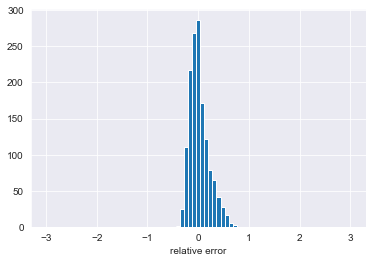

Text(0.5, 0, 'signed error (Re)')

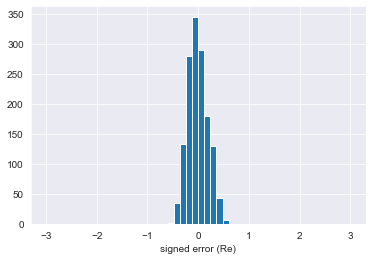

In [25]:
# Error for xgb

print(f'mean absolute error {np.abs((dict_pred[model_name]-y)).mean():.4f}')
print(f'median absolute error {np.abs((dict_pred[model_name]-y)).median():.4f}')
print(f'q95 absolute error {np.quantile(np.abs((dict_pred[model_name]-y)), 0.95):.4f}')

# Natural space
print('\nNatural space')
print(f'median relative error {np.abs((10**dict_pred[model_name]-10**y)/10**y).median()*100:.4f}')
print(f'q95 relative error {np.quantile(np.abs((10**dict_pred[model_name]-10**y)/10**y), 0.95)*100:.4f}')

print(f'median absolute error {np.abs((10**dict_pred[model_name]-10**y)).median()*100:.4f}')
print(f'q95 absolute error {np.quantile(np.abs((10**dict_pred[model_name]-10**y)), 0.95)*100:.4f}')

plt.hist((10**dict_pred[model_name]-10**y)/10**y, 75, range=(-3, 3))
plt.xlabel('relative error')
plt.show()

plt.hist((10**dict_pred[model_name]-10**y), 50, range=(-3,3))
plt.xlabel('signed error (Re)')

{'xgb':             boot_0    boot_1    boot_2    boot_3    boot_4  boot_5    boot_6  \
 date                                                                           
 2020-09-04     NaN -0.005711       NaN       NaN       NaN     NaN       NaN   
 2020-09-05     NaN       NaN -0.006803 -0.011435       NaN     NaN -0.019845   
 2020-09-06     NaN       NaN       NaN       NaN       NaN     NaN -0.019845   
 2020-09-07     NaN -0.043454       NaN       NaN       NaN     NaN       NaN   
 2020-09-08     NaN       NaN       NaN       NaN       NaN     NaN       NaN   
 ...            ...       ...       ...       ...       ...     ...       ...   
 2021-02-06     NaN       NaN  0.000294  0.089752 -0.000998     NaN       NaN   
 2021-02-07     NaN       NaN       NaN       NaN       NaN     NaN       NaN   
 2021-02-08     NaN       NaN       NaN  0.079592       NaN     NaN       NaN   
 2021-02-09     NaN       NaN       NaN       NaN       NaN     NaN       NaN   
 2021-02-10     NaN  